In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'

# 실행결과 경고메시지 출력 제외

import warnings

warnings.filterwarnings('ignore')

In [5]:
import os
os.getcwd()
os.chdir('/home/piai/바탕화면/유아용품')

In [6]:
df_raw = pd.read_csv('Sales_data.csv',encoding='utf-8')
df_raw

,주문번호,배송완료일,배송시작일,구매일,구매시월령,고객번호,구매금액,결제금액,물품대분류,상품명
0,901011864201303,2023-01-06,2023-01-02,2023-01-01,35.0,201901010750089,74560,43825,팬티,하기스 매직핏팬티 5단계 남아 124매(팬티형)
1,901011864430366,2023-01-04,2023-01-02,2023-01-01,9.0,201901010750143,74560,43825,팬티,하기스 매직핏팬티 3단계 남아 184매(팬티형)
2,81231186197954,2023-01-06,2023-01-02,2023-01-01,22.0,201812310749820,53920,36769,팬티,하기스 네이처메이드 팬티 5단계 여아 80매(팬티형)
3,812311863500220,2023-01-04,2023-01-02,2023-01-01,8.0,201812310750007,52160,32408,팬티,하기스 보송보송팬티 4단계 공용 124매(팬티형)
4,812311863220192,2023-01-04,2023-01-02,2023-01-01,23.0,201812310749977,47360,30066,팬티,하기스 에어솔솔 팬티 5단계 남아용 80매(팬티형)
...,...,...,...,...,...,...,...,...,...,...
199994,00806233401-26770461124511,2024-08-12,2024-08-09,2024-08-08,13.0,201906180918504,21300,14910,FC,라네이처 시그니처 울트라슬림 날개 중형 12개입 (EA)
199995,00806204436-0461904922687,2024-08-12,2024-08-09,2024-08-08,163.0,201901280776735,7900,5840,FC,라네이처 시그니처 맥시슬림 날개 중형 12개입 (EA)
199996,00806204436-0461904922688,2024-08-13,2024-08-09,2024-08-08,163.0,201901280776735,7100,5240,FC,라네이처 시그니처 울트라슬림 날개 대형 10개입 (EA)
199997,00806215930-05281256126202,2024-08-11,2024-08-09,2024-08-08,5.0,201906200921415,7100,5240,FC,라네이처 시그니처 울트라슬림 날개 소형 14개입 (EA)


In [7]:
df_raw.isnull().sum()

주문번호         0
배송완료일        0
배송시작일        0
구매일          0
구매시월령    31857
고객번호         0
구매금액         0
결제금액         0
물품대분류        0
상품명          0
dtype: int64

In [8]:
df_raw.columns

Index(['주문번호', '배송완료일', '배송시작일', '구매일', '구매시월령', '고객번호', '구매금액', '결제금액',
       '물품대분류', '상품명'],
      dtype='object')

In [9]:
print(df_raw['물품대분류'].unique())

['팬티' '체험팩' '물티슈' '더블하트' '기저귀' 'SKC' 'FMC' 'FC' '기타' 'SrC']


### 물품대분류 코드 추정 의미

| 코드 | 추정 의미 | 설명 |
|------|-----------|------|
| **SKC** | **Skin Care** | 유아용 스킨케어 제품 (로션, 크림, 오일 등)  
| **FMC** | **Feeding & Meal Care** | 젖병, 식판, 이유식 용품 등  
| **FC** | **Fashion & Clothing** | 유아복, 액세서리, 양말 등  
| **SrC** | **Stroller & Carseat** | 유모차, 카시트 등 이동 관련 용품  
| **기타** | 기타 | 위 항목에 해당되지 않는 제품군  


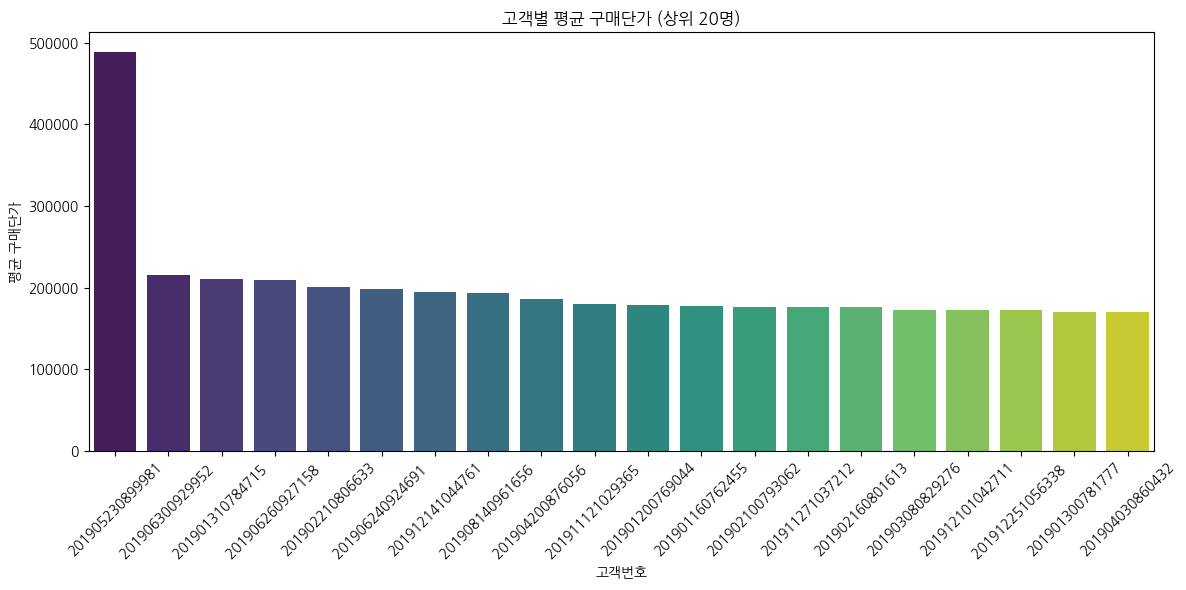

In [10]:
# 고객번호 기준으로 요약 집계
grouped = df_raw.groupby('고객번호').agg({
    '구매금액': 'sum',
    '결제금액': 'sum',
    '주문번호': 'count',
    '구매시월령': 'mean'
}).reset_index()

# 컬럼명 정리
grouped.columns = ['고객번호', '총구매금액', '총결제금액', '구매횟수', '평균월령']

# 평균 구매단가 파생변수 생성
grouped['평균구매단가'] = grouped['총결제금액'] / grouped['구매횟수']

# 평균 구매단가 상위 20명 시각화
top_avg_price = grouped.sort_values(by='평균구매단가', ascending=False).head(20)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=top_avg_price, x='고객번호', y='평균구매단가', palette='viridis')
plt.title("고객별 평균 구매단가 (상위 20명)")
plt.xlabel("고객번호")
plt.ylabel("평균 구매단가")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

구매단가 가장 높은 고객 -> 홈캠 구매

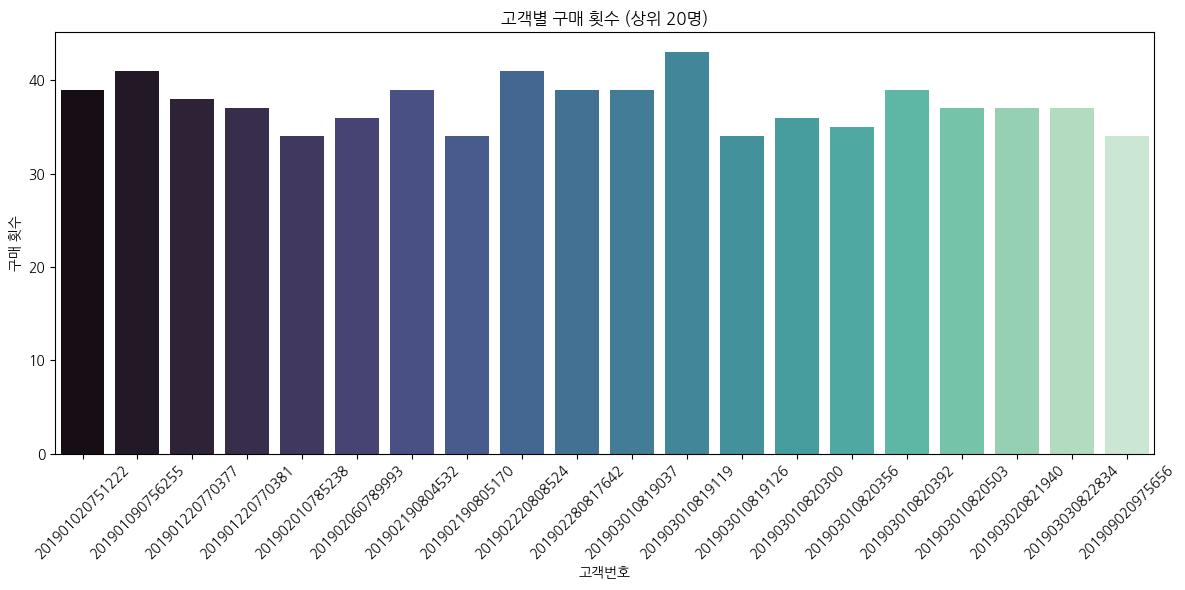

In [11]:
# 고객별 구매 횟수 상위 20명 시각화
top_purchase_count = grouped.sort_values(by='구매횟수', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_purchase_count, x='고객번호', y='구매횟수', palette='mako')
plt.title("고객별 구매 횟수 (상위 20명)")
plt.xlabel("고객번호")
plt.ylabel("구매 횟수")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
# 전체 고객 데이터를 기준으로 월령대 정의 (기존 구간 재사용)
df_raw['구매시월령'] = pd.to_numeric(df_raw['구매시월령'], errors='coerce')
df_raw = df_raw.dropna(subset=['구매시월령'])

# 월령대 구간 정의
bins = [0, 2, 5, 8, 12, 24, 36, 48, 60]
labels = ['0~2M', '3~5M', '6~8M', '9~12M', '13~24M', '25~36M', '37~48M', '49~60M']
df_raw['월령대'] = pd.cut(df_raw['구매시월령'], bins=bins, labels=labels, right=True)

# 맘큐 허그박스 제외
filtered_df = df_raw[~df_raw['상품명'].str.contains('맘큐 허그박스')]

# 월령대별 인기 상품 Top 3 추출
top_items_by_age_all = filtered_df.groupby(['월령대', '상품명'])['주문번호'] \
    .count().reset_index().sort_values(['월령대', '주문번호'], ascending=[True, False])

top3_per_age_all = top_items_by_age_all.groupby('월령대').head(3)
top3_per_age_all


,월령대,상품명,주문번호
2535,0~2M,하기스 네이처메이드 2단계 여아 156매(밴드형),1453
2532,0~2M,하기스 네이처메이드 2단계 남아 156매(밴드형),1314
1800,0~2M,더블하트 SofTouch 모유실감 젖꼭지 M (2입),1058
5423,3~5M,하기스 네이처메이드 3단계 여아 132매(밴드형),1185
4672,3~5M,더블하트 SofTouch 모유실감 젖꼭지 L (2입),1172
5418,3~5M,하기스 네이처메이드 3단계 남아 132매(밴드형),1102
7551,6~8M,더블하트 SofTouch 모유실감 젖꼭지 L (2입),810
7555,6~8M,더블하트 SofTouch 모유실감 젖꼭지 LL (2입),636
8302,6~8M,하기스 네이처메이드 3단계 여아 132매(밴드형),532
10434,9~12M,더블하트 SofTouch 모유실감 젖꼭지 LL (2입),480


전체 고객을 대상으로 분석한 **월령대별 인기 상품 TOP 3**:

---

### 🍼 **0~2개월 (신생아기)**  
1. 하기스 네이처메이드 2단계 여아 156매 (밴드형)  
2. 하기스 네이처메이드 2단계 남아 156매 (밴드형)  
3. 더블하트 SofTouch 모유실감 젖꼭지 M (2입)  
→ 출생 직후 기저귀와 젖꼭지 수요 집중

---

### 👶 **3~5개월**  
1. 하기스 네이처메이드 3단계 여아 132매 (밴드형)  
2. 더블하트 SofTouch 모유실감 젖꼭지 L (2입)  
→ 성장에 따라 기저귀 사이즈·젖꼭지 사이즈 변화가 반영됨

---

In [13]:
# 할인율(%) = (구매금액 - 결제금액) / 구매금액 * 100
# 숫자형으로 변환 (문자열로 되어 있는 경우 처리)
df_raw['구매금액'] = pd.to_numeric(df_raw['구매금액'], errors='coerce')
df_raw['결제금액'] = pd.to_numeric(df_raw['결제금액'], errors='coerce')

# 할인율 계산
df_raw['할인율(%)'] = ((df_raw['구매금액'] - df_raw['결제금액']) / df_raw['구매금액']) * 100

# 할인율 미리보기
df_raw[['구매금액', '결제금액', '할인율(%)']].head()

,구매금액,결제금액,할인율(%)
0,74560,43825,41.221835
1,74560,43825,41.221835
2,53920,36769,31.808234
3,52160,32408,37.868098
4,47360,30066,36.516047


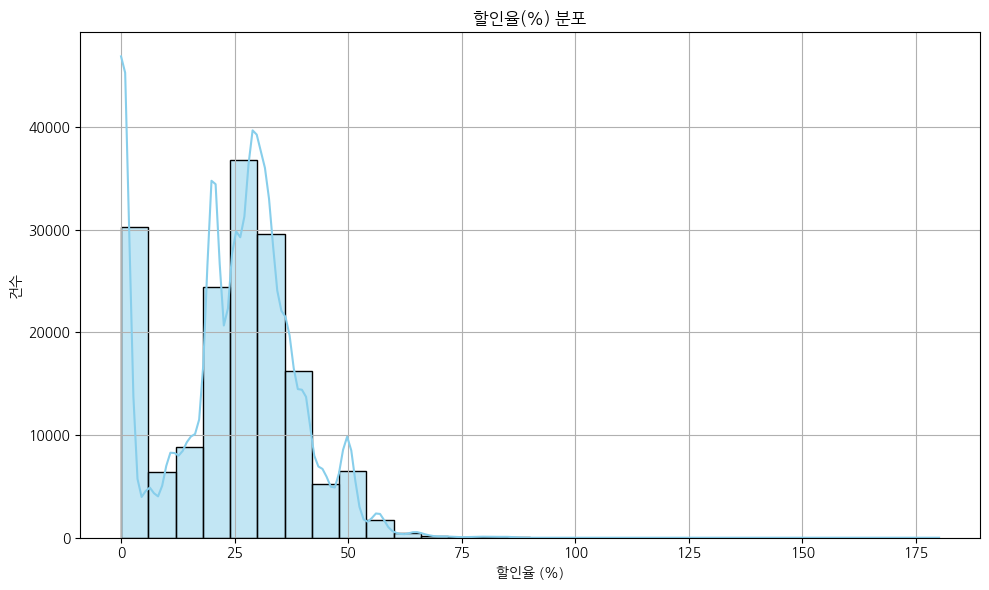

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 할인율 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(df_raw['할인율(%)'].dropna(), bins=30, kde=True, color='skyblue')
plt.title("할인율(%) 분포")
plt.xlabel("할인율 (%)")
plt.ylabel("건수")
plt.grid(True)
plt.tight_layout()
plt.show()


할인율 20~30% 구간에 구매 집중

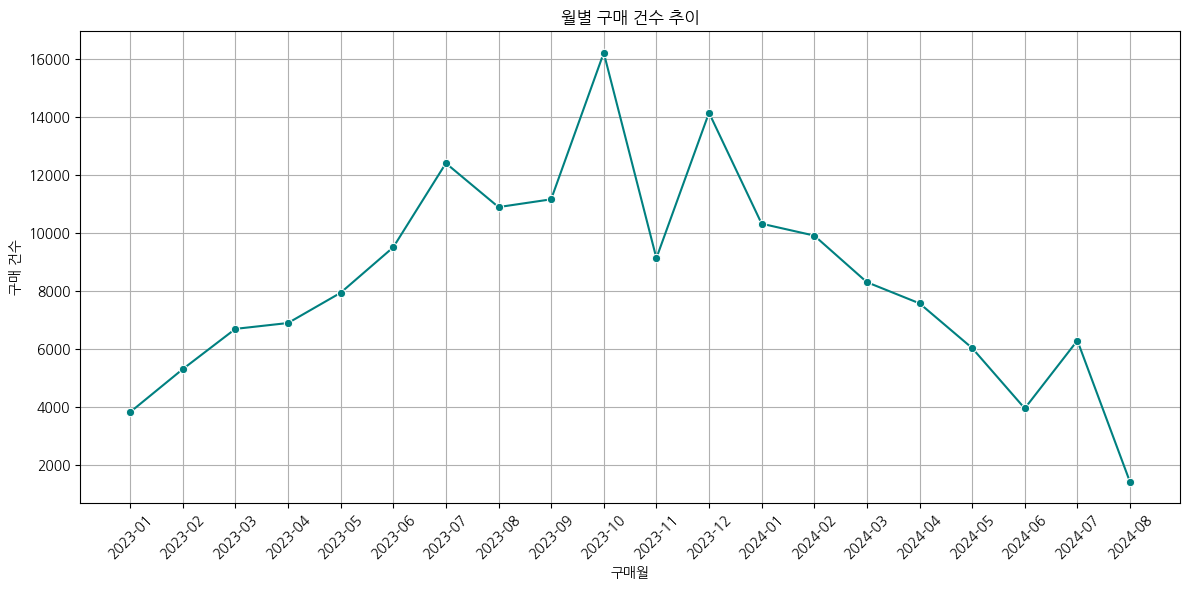

In [15]:
# 날짜 컬럼이 '구매일'일 것으로 가정하고 처리
df_raw['구매일'] = pd.to_datetime(df_raw['구매일'], errors='coerce')

# 월별 컬럼 생성
df_raw['구매월'] = df_raw['구매일'].dt.to_period('M').astype(str)

# 월별 구매 건수 집계
monthly_counts = df_raw['구매월'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values, marker='o', color='teal')
plt.title("월별 구매 건수 추이")
plt.xlabel("구매월")
plt.ylabel("구매 건수")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


10 > 12 > 7 월 순으로 구매 건수 많음

### 1. **시즌 전후 수요 분산 효과**

- **10월:**  
  → 출산 준비 수요 + 시즌 초기 할인 (ex. 가을 정기세일, 개월수 진입)  
- **12월:**  
  → 크리스마스, 연말정산, 기획전 등 쇼핑 피크  
- **11월:**  
  → **대기 수요** 발생:  
    “**곧 블프/연말 세일 시작되니까 좀만 기다리자**”  
  → 고객이 일부러 **구매를 미루는 심리** 생김  


월별 출생아 수 비중은 1월·10월(9.0%)에 가장 높음 <br>
출처) 통계청

In [16]:
# 월별 구매건수 재계산
df_raw['구매월'] = df_raw['구매일'].dt.to_period('M').astype(str)
monthly_counts = df_raw['구매월'].value_counts().sort_values(ascending=False)

# 가장 구매건수가 많은 월
top_month = monthly_counts.idxmax()
top_month_count = monthly_counts.max()

top_month, top_month_count

('2023-10', 16226)

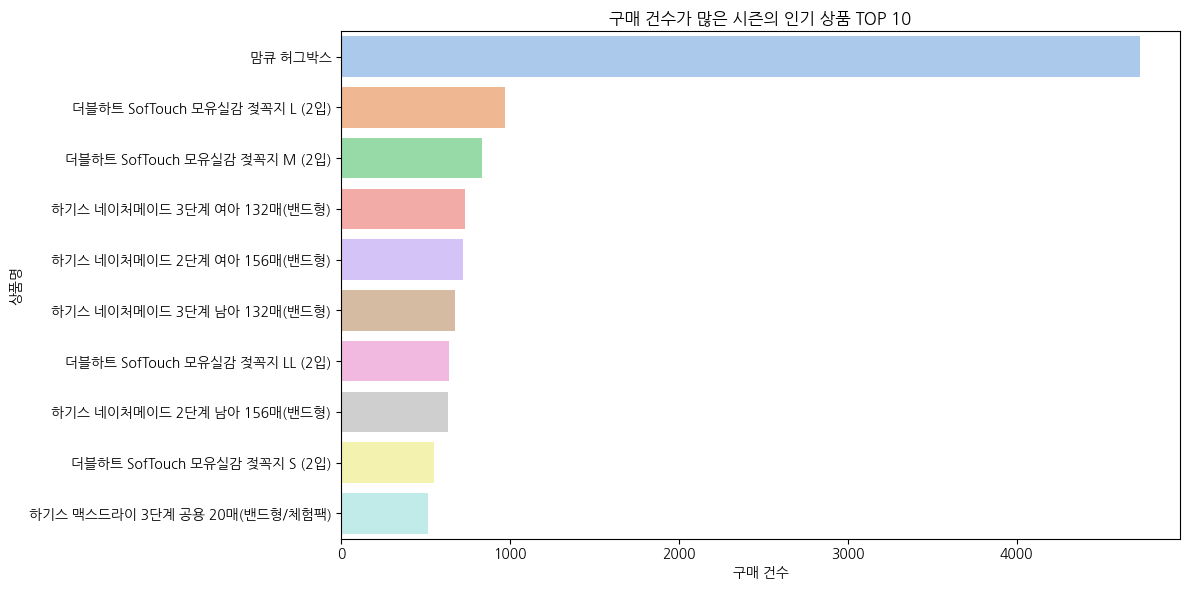

In [17]:
# 구매 건수가 많은 월 상위 3개 추출
monthly_counts = df_raw['구매일'].dt.to_period('M').value_counts().sort_values(ascending=False)
top_months = monthly_counts.head(3).index.astype(str).tolist()

# 상위 시즌 데이터 필터링
top_season_df = df_raw[df_raw['구매일'].dt.to_period('M').astype(str).isin(top_months)]

# 상품명 기준으로 상위 구매 상품 추출
top_items = top_season_df['상품명'].value_counts().head(10).reset_index()
top_items.columns = ['상품명', '구매건수']

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=top_items, x='구매건수', y='상품명', palette='pastel')
plt.title("구매 건수가 많은 시즌의 인기 상품 TOP 10")
plt.xlabel("구매 건수")
plt.ylabel("상품명")
plt.tight_layout()
plt.show()


# 맘큐 허그박스

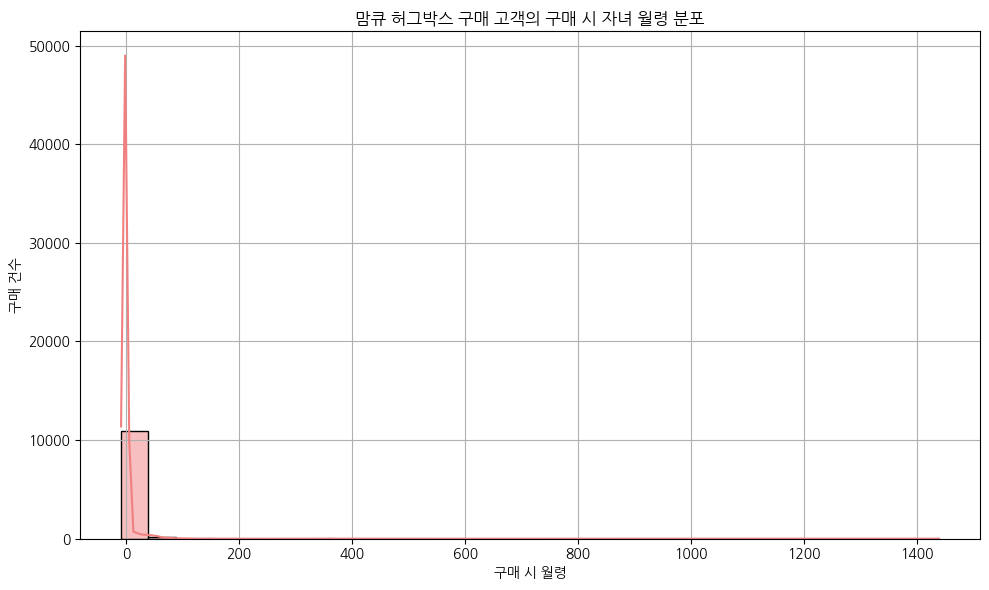

In [18]:
# 맘큐 허그박스 구매한 데이터만 필터링
mamq_df = df_raw[df_raw['상품명'].str.contains('맘큐 허그박스')].copy()

# 구매 시 월령 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(mamq_df['구매시월령'], bins=30, kde=True, color='lightcoral')
plt.title("맘큐 허그박스 구매 고객의 구매 시 자녀 월령 분포")
plt.xlabel("구매 시 월령")
plt.ylabel("구매 건수")
plt.grid(True)
plt.tight_layout()
plt.show()


---

### 📊 주요 해석 포인트:

- **0~3개월(신생아기)** 구간에 구매가 집중됨  
- 자녀 월령이 **1개월 전후일 때** 가장 많이 구매됨  
- 이는 맘큐 허그박스가 **출산 직후 초기 체험용 제품**으로 활용된다는 점을 반영함

---

### ✅ 실무 적용 예:
- 맘큐 허그박스를 **신생아 출산 직후 타겟 마케팅**에 활용  
- 월령 정보 기반 타겟팅 (0~3개월 대상 → 체험박스 쿠폰 발송 등)


맘큐 허그박스를 구매한 고객들은 맘큐 허그박스가 첫구매? <br>
그 이후 구매를 했는지 <br>
구매했다면 기저귀를 샀는지?

In [19]:
# 1. '구매일'을 날짜형으로 변환
df_raw['구매일'] = pd.to_datetime(df_raw['구매일'], errors='coerce')

# 2. 고객별 첫 구매일 구하기
first_purchase = df_raw.groupby('고객번호')['구매일'].min().reset_index()
first_purchase.columns = ['고객번호', '첫구매일']

# 3. 원데이터와 병합
df_merged = pd.merge(df_raw, first_purchase, on='고객번호', how='left')

# 4. 고객별 첫 구매 상품 중 맘큐 허그박스 구매 여부 확인
first_mamq = df_merged[
    (df_merged['구매일'] == df_merged['첫구매일']) &
    (df_merged['상품명'].str.contains('맘큐 허그박스'))
]

# 결과: 맘큐 허그박스가 첫 구매였던 고객 목록
mamq_first_buyers = first_mamq['고객번호'].unique()
print(f"맘큐 허그박스가 첫 구매였던 고객 수: {len(mamq_first_buyers)}명")


맘큐 허그박스가 첫 구매였던 고객 수: 10837명


분석 결과,  
**맘큐 허그박스를 첫 구매로 단독 구매**하고  
**그 이후 단 한 번의 재구매도 하지 않은 고객 수는 9,735명**

---

### 🔍 해석:
- 이들은 단지 **체험용 구매 후 이탈한 고객**일 가능성이 높으며  
- → **전환 마케팅, 리마인드 메시지, 맞춤 쿠폰 전략**이 필요

 - 이 사람들의 유입경로 분석해보기

첫 주문 시 다른 상품과 함께 구매했는지 / 이 함께 구매한 사람들의 재구매율??

In [20]:
# 1. 구매일 형식 정리
df_raw['구매일'] = pd.to_datetime(df_raw['구매일'], errors='coerce')

# 2. 고객별 첫 구매일자 구하기
first_purchase = df_raw.groupby('고객번호')['구매일'].min().reset_index()
first_purchase.columns = ['고객번호', '첫구매일']

# 3. 병합하여 첫 구매일 붙이기
df_merged = pd.merge(df_raw, first_purchase, on='고객번호', how='left')

# 4. 맘큐 허그박스를 첫 구매일에 산 고객 필터링
mamq_first = df_merged[
    (df_merged['상품명'].str.contains('맘큐 허그박스')) &
    (df_merged['구매일'] == df_merged['첫구매일'])
]

# 5. 해당 고객들의 전체 구매 중, 첫 구매일 이후 구매 여부 확인
mamq_first_customers = mamq_first['고객번호'].unique()
future_purchases = df_raw[
    (df_raw['고객번호'].isin(mamq_first_customers)) &
    (df_raw['구매일'] > df_raw.groupby('고객번호')['구매일'].transform('min'))
]

# 6. 재구매 고객 수
rebuyer_count = future_purchases['고객번호'].nunique()
total_mamq_first = len(mamq_first_customers)

print(f"맘큐 허그박스를 첫 구매로 산 고객 수: {total_mamq_first}명")
print(f"그 중 재구매한 고객 수: {rebuyer_count}명")


맘큐 허그박스를 첫 구매로 산 고객 수: 10837명
그 중 재구매한 고객 수: 1363명


그럼 재구매 한 고객들은 기저귀를 많이 샀을 거라 예상

맘큐 허그박스를 첫 구매로 선택하고, <br>
같은 날 다른 상품도 함께 구매한 고객 수: 총 196명

분석 결과,  
**맘큐 허그박스를 첫 구매로 하면서 다른 상품도 함께 구매한 196명 중**,  
**재구매까지 이어진 고객은 90명**

---

### ✅ 전환률 정리

- 첫 구매 시 맘큐 + 다른 상품 동시 구매 고객: **196명**
- 이 중 재구매한 고객: **90명**
- → **전환률 약 45.9%**

📌 단독 구매 고객 대비 훨씬 높은 재구매율로,  
**동시 구매 고객은 충성 고객으로 전환될 가능성이 높음**을 보여줌

이 90명이 이후에 어떤 상품을 재구매했는지?

--> 하기스 기저귀 시리즈 다양한 단계별, 더블하트 젖꼭지 시리별 사이즈 고르게 재구매됨 <br>
==> 이 고객들은 이제 정기적으로 구매하는 충성고객 후보로 예상 <br>
    - 자동배송, 멤버십, 세트 추천 마케팅 등으로 전환률 더 끌어올릴 수 있음

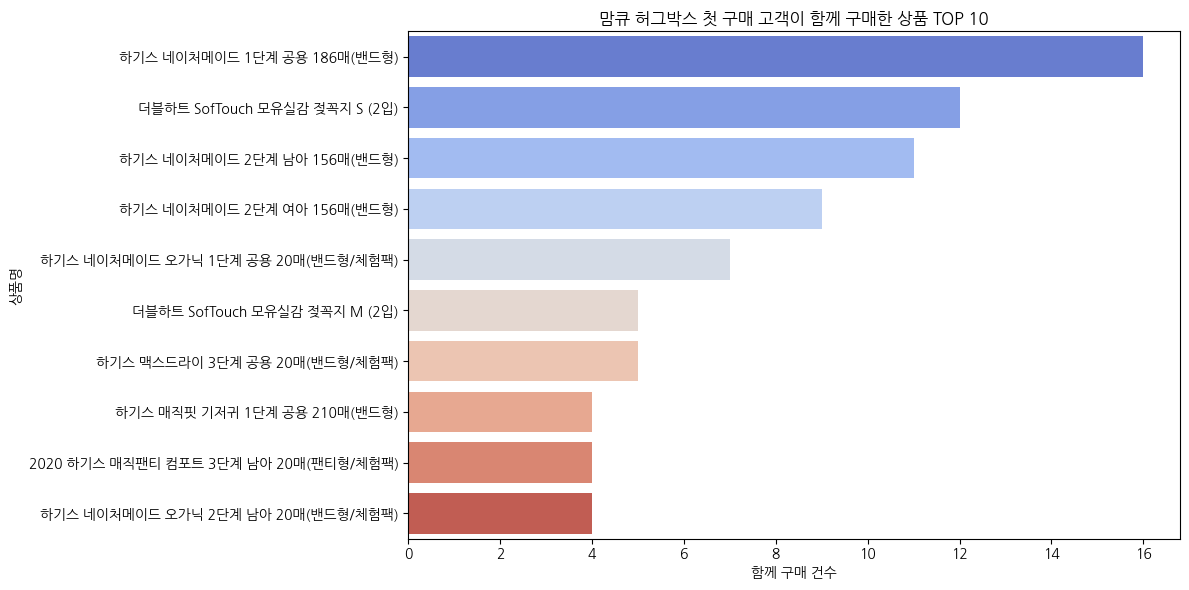

In [21]:
# 1. 맘큐 허그박스를 첫 구매로 한 고객 + 첫 구매일
mamq_first_key = mamq_first[['고객번호', '첫구매일']]

# 2. 같은 고객, 같은 날 구매한 모든 상품
same_day_purchases = pd.merge(mamq_first_key, df_raw, how='inner',
                              left_on=['고객번호', '첫구매일'],
                              right_on=['고객번호', '구매일'])

# 3. 맘큐 허그박스를 제외한 다른 상품만 추출
other_items = same_day_purchases[~same_day_purchases['상품명'].str.contains('맘큐 허그박스')]

# 4. 함께 구매된 상품 Top 10
paired_items = other_items['상품명'].value_counts().head(10).reset_index()
paired_items.columns = ['상품명', '함께구매건수']

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=paired_items, y='상품명', x='함께구매건수', palette='coolwarm')
plt.title("맘큐 허그박스 첫 구매 고객이 함께 구매한 상품 TOP 10")
plt.xlabel("함께 구매 건수")
plt.ylabel("상품명")
plt.tight_layout()
plt.show()




### 🏆 함께 많이 구매된 상품 TOP 3
1. **더블하트 SofTouch 모유실감 젖꼭지 (L, M, LL)**  
2. **하기스 기저귀 시리즈 (밴드형/팬티형)**  
3. **더블하트 젖병 & 세척 관련 상품**

---

### ✅ 인사이트
- **맘큐 허그박스는 단독 구매보다 육아 필수템과 함께 묶여 구매되는 경우가 많음**  
- 신생아 초기 세트 구성으로도 추천 가능 (→ 패키징 상품 기획 전략에 활용 가능)  
- 더블하트 제품과 함께 구매되는 경향 → 제휴 마케팅 여지 있음


# 스마트 프리미엄 멤버십 가입선물 - 기저귀

첫

In [22]:
# '스마트 프리미엄 멤버십 가입선물'을 구매한 고객 수 재확인
premium_gift_customers = df_raw[df_raw['상품명'].str.contains('스마트 프리미엄 멤버십 가입선물', na=False)]
premium_gift_customer_count = premium_gift_customers['고객번호'].nunique()

premium_gift_customer_count


76

# RFM 분석

In [23]:
# 코드 실행 상태 초기화로 필요한 라이브러리와 데이터 다시 로드
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# 날짜 변환
df_raw['구매일'] = pd.to_datetime(df_raw['구매일'], errors='coerce')

# 기준일: 가장 마지막 구매일 + 1일
today = df_raw['구매일'].max() + pd.Timedelta(days=1)

# RFM 계산
rfm = df_raw.groupby('고객번호').agg({
    '구매일': lambda x: (today - x.max()).days,  # Recency
    '주문번호': 'count',                         # Frequency
    '결제금액': 'sum'                            # Monetary
}).reset_index()

rfm.columns = ['고객번호', 'Recency', 'Frequency', 'Monetary']

# RFM 점수화 (1~5점, 높을수록 우수)
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)

# RFM 지수 결합
rfm['RFM지수'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm.head()

,고객번호,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM지수
0,201812310749735,461,1,16314,1,1,3,113
1,201812310749771,454,1,47922,1,1,4,114
2,201812310749774,377,2,116532,2,3,5,235
3,201812310749780,557,1,19900,1,1,3,113
4,201812310749784,316,3,72012,2,4,4,244
